# The Unscented Kalman Filter

In [136]:
%matplotlib inline

In [137]:
from copy import deepcopy
import sys
import numpy as np
from numpy import eye, zeros, dot, isscalar, outer
from scipy.linalg import cholesky
from filterpy.kalman import unscented_transform
import math
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn
import numpy as np
from scipy.linalg import cholesky

## The Unscented Transform

For the moment, assume an algorithm for selecting the sigma points and weights exists. How are the sigma points used to implement a filter?

The *unscented transform* is the core of the algorithm yet it is remarkably simple. It passes the sigma points $\boldsymbol{\chi}$ through a nonlinear function yielding a transformed set of points. 

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi})$$

It then computes the mean and covariance of the transformed points. That mean and covariance becomes the new estimate. The figure below depicts the operation of the unscented transform. The green ellipse on the right represents the computed mean and covariance to the transformed sigma points. 

The mean and covariance of the sigma points are computed as:

$$\begin{aligned}
\mu &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal{Y}}_i \\
\Sigma &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal{Y}}_i-\mu)(\boldsymbol{\mathcal{Y}}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

These equations should be familiar - they are the constraint equations we developed above. 

In short, the unscented transform takes points sampled from some arbitary probability distribution, passes them through an arbitrary, nonlinear function and produces a Gaussian for each transformed points. I hope you can envision how we can use this to implement a nonlinear Kalman filter. Once we have Gaussians all of the mathematical apparatus we have already developed comes into play!

The name "unscented" might be confusing. It doesn't really mean much. It was a joke fostered by the inventor that his algorithm didn't "stink", and soon the name stuck. There is no mathematical meaning to the term.

## The Unscented Kalman Filter

We can now present the UKF algorithm. 

### Predict Step

The UKF's predict step computes the prior using the process model $f()$. $f()$ is assumed to be nonlinear, so we generate sigma points $\mathcal{X}$ and their corresponding weights $W^m, W^c$
according to some function:

$$\begin{aligned}
\boldsymbol\chi &= \text{sigma-function}(\mathbf x, \mathbf P) \\
W^m, W^c &= \text{weight-function}(\mathtt{n, parameters})\end{aligned}$$

We pass each sigma point through $f(\mathbf x, \Delta t)$. This projects the sigma points forward in time according to the process model, forming the new prior, which is a set of sigma points we name $\boldsymbol{\mathcal Y}$:

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi}, \Delta t)$$

We compute the mean and covariance of the prior using the *unscented transform* on the transformed sigma points.  

$$\mathbf{\bar x}, \mathbf{\bar P} = 
UT(\mathcal{Y}, w_m, w_c, \mathbf Q)$$

These are the equations for the unscented transform:

$$\begin{aligned}
\mathbf{\bar x} &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Y}_i \\
\mathbf{\bar P} &= \sum_{i=0}^{2n} w^c_i({\boldsymbol{\mathcal Y}_i - \mathbf{\bar x})(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})^\mathsf{T}} + \mathbf Q
\end{aligned}
$$

This table compares the linear Kalman filter with the Unscented Kalman Filter equations. I've dropped the subscript $i$ for readability.

$$\begin{array}{l|l}
\text{Kalman} & \text{Unscented} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q
\end{array}$$

### Update Step

Kalman filters perform the update in measurement space. Thus we must convert the sigma points of the prior into measurements using a measurement function $h(x)$ that you define.

$$\boldsymbol{\mathcal{Z}} = h(\boldsymbol{\mathcal{Y}})$$

We compute the mean and covariance of these points using the unscented transform. The $z$ subscript denotes that these are the mean and covariance of the measurement sigma points.

$$\begin{aligned}
\boldsymbol\mu_z, \mathbf P_z &= 
UT(\boldsymbol{\mathcal Z}, w_m, w_c, \mathbf R) \\
\boldsymbol\mu_z &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Z}_i \\
\mathbf P_z &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)^\mathsf T} + \mathbf R
\end{aligned}
$$

Next we compute the residual and Kalman gain. The residual of the measurement $\mathbf z$ is trivial to compute:

$$\mathbf y = \mathbf z - \boldsymbol\mu_z$$

To compute the Kalman gain we first compute the [cross covariance](https://en.wikipedia.org/wiki/Cross-covariance) of the state and the measurements, which is defined as: 

$$\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})(\boldsymbol{\mathcal Z}_i-\boldsymbol\mu_z)^\mathsf T$$

And then the Kalman gain is defined as

$$\mathbf{K} = \mathbf P_{xz} \mathbf P_z^{-1}$$

If you think of the inverse as a *kind of* matrix reciprocal, you can see that the Kalman gain is a simple ratio which computes:

$$\mathbf{K} \approx \frac{\mathbf P_{xz}}{\mathbf P_z} 
\approx \frac{\text{belief in state}}{\text{belief in measurement}}$$

Finally, we compute the new state estimate using the residual and Kalman gain:

$$\mathbf x = \bar{\mathbf x} + \mathbf{Ky}$$

and the new covariance is computed as:

$$ \mathbf P = \mathbf{\bar P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}$$

This step contains a few equations you have to take on faith, but you should be able to see how they relate to the linear Kalman filter equations. The linear algebra is slightly different from the linear Kalman filter, but the algorithm is the same Bayesian algorithm we have been implementing throughout the book. 

This table compares the equations of the linear KF and UKF equations.

$$\begin{array}{l|l}
\textrm{Kalman Filter} & \textrm{Unscented Kalman Filter} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T+\mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q \\
\hline 
& \boldsymbol{\mathcal Z} =  h(\boldsymbol{\mathcal{Y}}) \\
& \boldsymbol\mu_z = \sum w^m\boldsymbol{\mathcal{Z}} \\
\mathbf y = \mathbf z - \mathbf{Hx} &
\mathbf y = \mathbf z - \boldsymbol\mu_z \\
\mathbf S = \mathbf{H\bar PH}^\mathsf{T} + \mathbf R & 
\mathbf P_z = \sum w^c{(\boldsymbol{\mathcal Z}-\boldsymbol\mu_z)(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}} + \mathbf R \\ 
\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf S^{-1} &
\mathbf K = \left[\sum w^c(\boldsymbol{\mathcal Y}-\bar{\mathbf x})(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}\right] \mathbf P_z^{-1} \\
\mathbf x = \mathbf{\bar x} + \mathbf{Ky} & \mathbf x = \mathbf{\bar x} + \mathbf{Ky}\\
\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P} & \mathbf P = \bar{\mathbf P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}
\end{array}$$

### Sigma Point Computation

The first sigma point is the mean of the input. This is the sigma point displayed in the center of the ellipses in the diagram above. We will call this $\boldsymbol{\chi}_0$.

$$ \mathcal{X}_0 = \mu$$

For notational convenience we define $\lambda = \alpha^2(n+\kappa)-n$, where $n$ is the dimension of $\mathbf x$. The remaining sigma points are computed as

$$ 
\boldsymbol{\chi}_i = \begin{cases}
\mu + \left[ \sqrt{(n+\lambda)\Sigma}\right ]_{i}& i=1..n \\
\mu - \left[ \sqrt{(n+\lambda)\Sigma}\right]_{i-n} &i=(n+1)..2n\end{cases}
$$
The $i$ subscript chooses the i$^{th}$ row vector of the matrix.

In other words, we scale the covariance matrix by a constant, take the square root of it, and ensure symmetry by both adding and subtracting it from the mean. We will discuss how you take the square root of a matrix later.

### Weight Computation

This formulation uses one set of weights for the means, and another set for the covariance. The weights for the mean of $\mathcal{X}_0$ is computed as

$$W^m_0 = \frac{\lambda}{n+\lambda}$$

The weight for the covariance of $\mathcal{X}_0$ is

$$W^c_0 = \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta$$

The weights for the rest of the sigma points $\boldsymbol{\chi}_1 ... \boldsymbol{\chi}_{2n}$ are the same for the mean and covariance. They are

$$W^m_i = W^c_i = \frac{1}{2(n+\lambda)}\;\;\;i=1..2n$$

It may not be obvious why this is 'correct', and indeed, it cannot be proven that this is ideal for all nonlinear problems. But you can see that we are choosing the sigma points proportional to the square root of the covariance matrix, and the square root of variance is standard deviation. So, the sigma points are spread roughly according to $\pm 1\sigma$ times some scaling factor. There is an $n$ term in the denominator, so with more dimensions the points will be spread out and weighed less.

**Important note:** Ordinarily these weights do not sum to one. I get many questions about this. Getting weights that sum to greater than one, or even negative values is expected. I cover this in more detail below.


### Reasonable Choices for the Parameters

$\beta=2$ is a good choice for Gaussian problems, $\kappa=3-n$ where $n$ is the dimension of $\mathbf x$ is a good choice for $\kappa$, and $0 \le \alpha \le 1$ is an appropriate choice for $\alpha$, where a larger value for $\alpha$ spreads the sigma points further from the mean.

### Tracking a Moving Vehicle in Two Dimensions

Consider the problem of tracking a moving vehicle in two dimensions (north is one dimension and east is
the other dimension). The vehicle’s acceleration in the north and east directions consists of independent
white noise. Two tracking stations, located at north-east coordinates $(𝑁_1, 𝐸_1)$ and $(𝑁_2, 𝐸_2)$,
respectively, measure the range to the vehicle. The system model can therefore be written as
$$\mathbf{F} = \begin{bmatrix} 1 & 0 & \Delta t &0 \\ 0& 1& 0 &\Delta t\\ 0&0&1&0 \\ 0&0&0&1\end{bmatrix}$$
$$ \\\dot x = \mathbf{F}x + w_k $$
$$ x = \begin{bmatrix}n \\\dot n\\ e\\ \dot e\end{bmatrix} $$

$$y_k = \begin{bmatrix} \sqrt{(n_k -N_1)^2 + (e_k - E_1)^2} \\\sqrt{(n_k -N_2)^2 + (e_k - E_2)^2}\end{bmatrix} + v_k $$

where $n_k$ and $e_k$ are the vehicle’s north and east coordinates at time step 𝑘, $\Delta t$ is the time step of the
system, $w_k$ is the zero-mean process noise, and $v_k$ is the zero-mean measurement noise. Suppose that
the time step $\Delta t = 0.1 s$, the process noise covariance $𝑄 = diag(0, 0,4,4)$, and the measurement noise
covariance $𝑅 = diag(1,1)$. The tracking stations are located at $(𝑁_1, 𝐸_1) = (20,0)$, and $(𝑁_2, 𝐸_2) =
(0,20)$. The initial state of the vehicle $𝑥_0 = [0; 0; 50; 50]$ and is perfectly known. Design an unscented
Kalman filter to estimate the state of the vehicle. Run the simulation for 60 s. Plot the estimation error
for the four states. [Optimal State Estimation, Dan Simon, Wiley, 2003]


In [138]:
class UnscentedKalmanFilter(object):

    def __init__(self, dim_x, dim_z, dt, hx, fx, points,
                 sqrt_fn=None, x_mean_fn=None, z_mean_fn=None,
                 residual_x=None,
                 residual_z=None):

        self.x = zeros(dim_x)
        self.P = eye(dim_x)
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)
        self.Q = eye(dim_x)
        self.R = eye(dim_z)
        self._dim_x = dim_x
        self._dim_z = dim_z
        self.points_fn = points
        self._dt = dt
        self._num_sigmas = points.num_sigmas()
        self.hx = hx
        self.fx = fx
        self.x_mean = x_mean_fn
        self.z_mean = z_mean_fn

        # Only computed only if requested via property
        self._log_likelihood = log(sys.float_info.min)
        self._likelihood = sys.float_info.min
        self._mahalanobis = None

        if sqrt_fn is None:
            self.msqrt = cholesky
        else:
            self.msqrt = sqrt_fn

        # weights for the means and covariances.
        self.Wm, self.Wc = points.Wm, points.Wc

        if residual_x is None:
            self.residual_x = np.subtract
        else:
            self.residual_x = residual_x

        if residual_z is None:
            self.residual_z = np.subtract
        else:
            self.residual_z = residual_z

        # sigma points transformed through f(x) and h(x)
        # variables for efficiency so we don't recreate every update

        self.sigmas_f = zeros((self._num_sigmas, self._dim_x))
        self.sigmas_h = zeros((self._num_sigmas, self._dim_z))

        self.K = np.zeros((dim_x, dim_z))    # Kalman gain
        self.y = np.zeros((dim_z))           # residual
        self.z = np.array([[None]*dim_z]).T  # measurement
        self.S = np.zeros((dim_z, dim_z))    # system uncertainty
        self.SI = np.zeros((dim_z, dim_z))   # inverse system uncertainty

        self.inv = np.linalg.inv

        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def predict(self, dt=None, UT=None, fx=None, **fx_args):
        if dt is None:
            dt = self._dt

        if UT is None:
            UT = unscented_transform

        # calculate sigma points for given mean and covariance
        self.compute_process_sigmas(dt, fx, **fx_args)

        # and pass sigmas through the unscented transform to compute prior
        self.x, self.P = UT(self.sigmas_f, self.Wm, self.Wc, self.Q,
                            self.x_mean, self.residual_x)

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)

    def update(self, z, R=None, UT=None, hx=None, **hx_args):
        if z is None:
            self.z = np.array([[None]*self._dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return

        if hx is None:
            hx = self.hx

        if UT is None:
            UT = unscented_transform

        if R is None:
            R = self.R
        elif isscalar(R):
            R = eye(self._dim_z) * R

        # pass prior sigmas through h(x) to get measurement sigmas
        # the shape of sigmas_h will vary if the shape of z varies, so
        # recreate each time
        sigmas_h = []
        for s in self.sigmas_f:
            sigmas_h.append(hx(s, **hx_args))

        self.sigmas_h = np.atleast_2d(sigmas_h)

        # mean and covariance of prediction passed through unscented transform
        zp, self.S = UT(self.sigmas_h, self.Wm, self.Wc,
                        R, self.z_mean, self.residual_z)
        self.SI = self.inv(self.S)

        # compute cross variance of the state and the measurements
        Pxz = self.cross_variance(self.x, zp, self.sigmas_f, self.sigmas_h)

        self.K = dot(Pxz, self.SI)        # Kalman gain
        self.y = self.residual_z(z, zp)   # residual

        # update Gaussian state estimate (x, P)
        self.x = self.x + dot(self.K, self.y)
        self.P = self.P - dot(self.K, dot(self.S, self.K.T))

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

        # set to None to force recompute
        self._log_likelihood = None
        self._likelihood = None
        self._mahalanobis = None

    def cross_variance(self, x, z, sigmas_f, sigmas_h):
        Pxz = zeros((sigmas_f.shape[1], sigmas_h.shape[1]))
        N = sigmas_f.shape[0]
        for i in range(N):
            dx = self.residual_x(sigmas_f[i], x)
            dz = self.residual_z(sigmas_h[i], z)
            Pxz += self.Wc[i] * outer(dx, dz)
        return Pxz

    def compute_process_sigmas(self, dt, fx=None, **fx_args):
        if fx is None:
            fx = self.fx

        # calculate sigma points for given mean and covariance
        sigmas = self.points_fn.sigma_points(self.x, self.P)

        for i, s in enumerate(sigmas):
            self.sigmas_f[i] = fx(s, dt, **fx_args)

    def rts_smoother(self, Xs, Ps, Qs=None, dts=None, UT=None):
        if len(Xs) != len(Ps):
            raise ValueError('Xs and Ps must have the same length')

        n, dim_x = Xs.shape

        if dts is None:
            dts = [self._dt] * n
        elif isscalar(dts):
            dts = [dts] * n

        if Qs is None:
            Qs = [self.Q] * n

        if UT is None:
            UT = unscented_transform

        # smoother gain
        Ks = zeros((n, dim_x, dim_x))

        num_sigmas = self._num_sigmas

        xs, ps = Xs.copy(), Ps.copy()
        sigmas_f = zeros((num_sigmas, dim_x))

        for k in reversed(range(n-1)):
            # create sigma points from state estimate, pass through state func
            sigmas = self.points_fn.sigma_points(xs[k], ps[k])
            for i in range(num_sigmas):
                sigmas_f[i] = self.fx(sigmas[i], dts[k])

            xb, Pb = UT(
                sigmas_f, self.Wm, self.Wc, self.Q,
                self.x_mean, self.residual_x)

            # compute cross variance
            Pxb = 0
            for i in range(num_sigmas):
                y = self.residual_x(sigmas_f[i], xb)
                z = self.residual_x(sigmas[i], Xs[k])
                Pxb += self.Wc[i] * outer(z, y)

            # compute gain
            K = dot(Pxb, self.inv(Pb))

            # update the smoothed estimates
            xs[k] += dot(K, self.residual_x(xs[k+1], xb))
            ps[k] += dot(K, ps[k+1] - Pb).dot(K.T)
            Ks[k] = K

        return (xs, ps, Ks)

In [139]:
class MerweScaledSigmaPoints(object):
    def __init__(self, n, alpha, beta, kappa, sqrt_method=None, subtract=None):
        # pylint: disable=too-many-arguments

        self.n = n
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa
        if sqrt_method is None:
            self.sqrt = cholesky
        else:
            self.sqrt = sqrt_method

        if subtract is None:
            self.subtract = np.subtract
        else:
            self.subtract = subtract

        self._compute_weights()

    def num_sigmas(self):
        """ Number of sigma points for each variable in the state x"""
        return 2*self.n + 1

    def sigma_points(self, x, P):
        if self.n != np.size(x):
            raise ValueError("expected size(x) {}, but size is {}".format(
                self.n, np.size(x)))

        n = self.n

        if np.isscalar(x):
            x = np.asarray([x])

        if np.isscalar(P):
            P = np.eye(n)*P
        else:
            P = np.atleast_2d(P)

        lambda_ = self.alpha**2 * (n + self.kappa) - n
        U = self.sqrt((lambda_ + n)*P)

        sigmas = np.zeros((2*n+1, n))
        sigmas[0] = x
        for k in range(n):
            # pylint: disable=bad-whitespace
            sigmas[k+1] = self.subtract(x, -U[k])
            sigmas[n+k+1] = self.subtract(x, U[k])

        return sigmas

    def _compute_weights(self):
        """ Computes the weights for the scaled unscented Kalman filter.

        """

        n = self.n
        lambda_ = self.alpha**2 * (n + self.kappa) - n

        c = .5 / (n + lambda_)
        self.Wc = np.full(2*n + 1, c)
        self.Wm = np.full(2*n + 1, c)
        self.Wc[0] = lambda_ / (n + lambda_) + (1 - self.alpha**2 + self.beta)
        self.Wm[0] = lambda_ / (n + lambda_)

In [140]:
def f_cv(x, dt):
    " Dynamics model"
    F = np.array([[1, 0, dt,  0],
                  [0,  1, 0,  dt],
                  [0,  0, 1, 0],
                  [0,  0, 0,  1]])
    x = F @ x
    return x
    # return [x[0], x[1], x[2] + randn() * 2, x[2] + randn() * 2]

def h_cv(x):
    " Measurement model"
    dn1 = x[0] - 20
    de1 = x[1]
    dn2 = x[0]
    de2 = x[1] - 20
    north_range = math.sqrt(dn1**2 + de1**2)
    east_range = math.sqrt(dn2**2 + de2**2)
    # return [north_range + randn(), east_range + randn()]
    return [north_range, east_range]

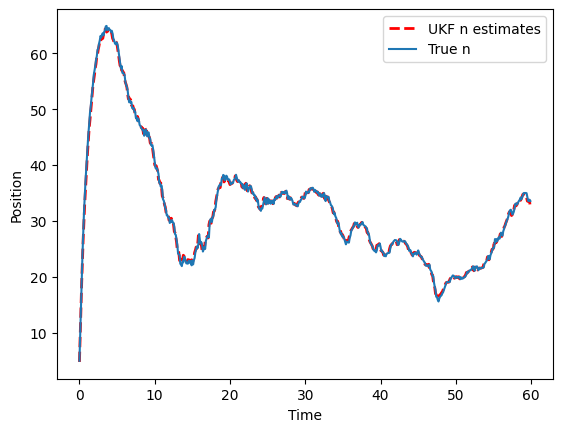

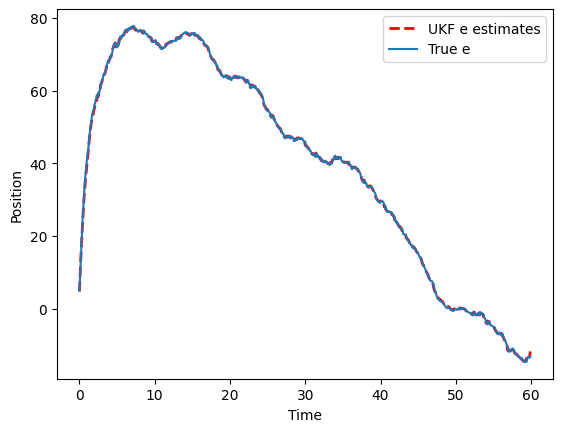

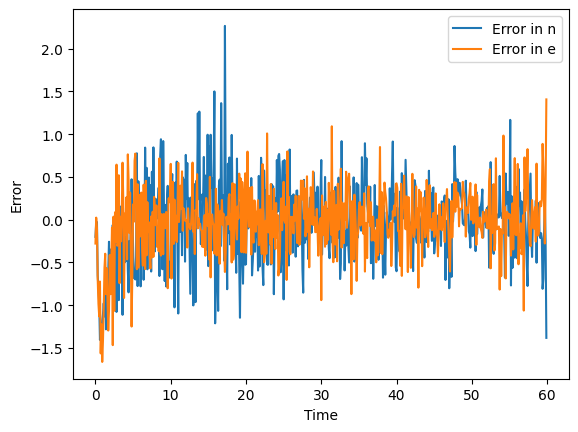

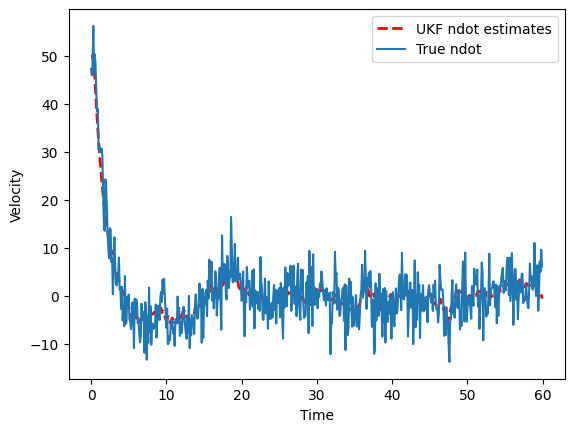

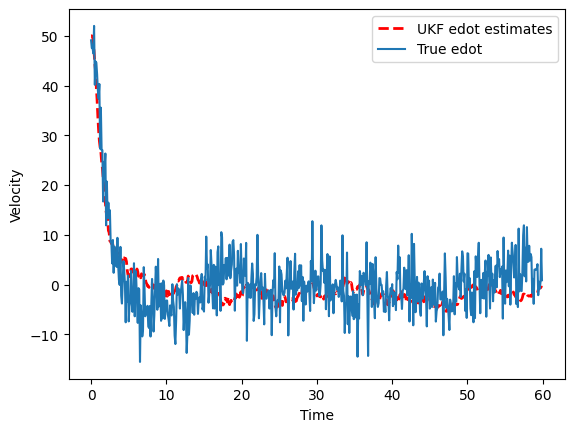

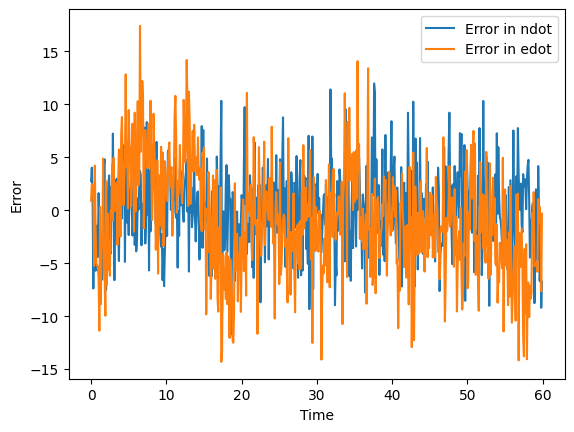

In [151]:
std_x, std_y = 1, 1
dt = 0.1

sigmas = MerweScaledSigmaPoints(4, alpha=0.5, beta=2., kappa=-1)
ukf = UnscentedKalmanFilter(dim_x=4, dim_z=2, fx=f_cv,
                            hx=h_cv, dt=dt, points=sigmas)
ukf.Q = np.diag([0, 0, 4, 4])
ukf.R = np.diag([10, 10])
x0 = np.array([0, 0, 50, 50])
ukf.x = x0 

uxs = []
xtrue = []
measuremetns = []
for i in range(600):
    y = h_cv(ukf.x)
    x = f_cv(ukf.x, dt)
    z = [y[0] + randn()*std_x, y[1] + randn()*std_y]
    x = [x[0], x[1], x[2] + randn() * 4, x[2] + randn() * 4]
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
    xtrue.append(x.copy())
    measuremetns.append(z)

uxs = np.array(uxs)
xtrue = np.array(xtrue)
measuremetns = np.array(measuremetns)
t = np.arange(0, 60, 0.1)

# True n, Estimated n
plt.plot(t, uxs[:, 0],
         color='red', linewidth=2, linestyle='--', label='UKF n estimates')
plt.plot(t, xtrue[:, 0], 
         label='True n')

# plt.plot(t, xtrue[:, 0], 
#          marker='x', ls='', linewidth=2,)
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(loc='upper right')


plt.figure()
# True e, Estimated e
plt.plot(t, uxs[:, 1],
         color='red', linewidth=2, linestyle='--', label='UKF e estimates')
plt.plot(t, xtrue[:, 1], label='True e')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(loc='upper right')


plt.figure()
# Error
plt.plot(t, uxs[:, 0] - xtrue[:, 0], label='Error in n')
plt.plot(t, uxs[:, 1] - xtrue[:, 1], label='Error in e')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend(loc='upper right')


plt.figure()
# True ndot, Estimated ndot
plt.plot(t, uxs[:, 2],
         color='red', linewidth=2, linestyle='--', label='UKF ndot estimates')
plt.plot(t, xtrue[:, 2], label='True ndot')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend(loc='upper right')

plt.figure()
# True edot, Estimated edot
plt.plot(t, uxs[:, 3], color='red', linewidth=2, linestyle='--',
             label='UKF edot estimates')
plt.plot(t, xtrue[:, 3],
        label='True edot')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Velocity')

plt.figure()
# Error
plt.plot(t, uxs[:, 2] - xtrue[:, 2], label='Error in ndot')
plt.plot(t, uxs[:, 3] - xtrue[:, 3], label='Error in edot')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend(loc='upper right')

plt.show()

## References

- [1] Rudolph Van der Merwe. "Sigma-Point Kalman Filters for Probabilistic Inference in Dynamic State-Space Models" dissertation (2004).

- [2] Simon J. Julier. "The Scaled Unscented Transformation". Proceedings of the American Control Conference 6. IEEE. (2002)

- [3] http://www.esdradar.com/brochures/Compact%20Tracking%2037250X.pdf

- [4] Julier, Simon J.; Uhlmann, Jeffrey "A New Extension of the Kalman  Filter to Nonlinear Systems". Proc. SPIE 3068, Signal Processing, Sensor Fusion, and Target Recognition VI, 182 (July 28, 1997)

- [5] Cholesky decomposition. Wikipedia. http://en.wikipedia.org/wiki/Cholesky_decomposition

- [6] Optimal State Estimation, Dan Simon, Wiley, 2003

- [7] https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/tree/master
